In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

1

In [11]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### Preparing dataset 

In [12]:
# TDC Tox
DSdataset_name = 'DrugBank' #'TWOSIDES' #'DrugBank'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [13]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [14]:
data = DDI(name = DSdataset_name).get_data(format = 'df')

Found local copy...
Loading...
Done!


In [15]:
# from tdc.utils import get_label_map
# get_label_map(name = 'DrugBank', task = 'DDI')


In [16]:
# data = Tox(name = DSdataset_name).get_data(format = 'df')
# smiles, labels = data['Drug'], data['Y']

In [17]:
data

,Drug1_ID,Drug1,Drug2_ID,Drug2,Y
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
1,DB00855,NCC(=O)CCC(O)=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
2,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
...,...,...,...,...,...
191803,DB00437,OC1=NC=NC2=C1C=NN2,DB00492,CCC(=O)O[C@@H](O[P@](=O)(CCCCC1=CC=CC=C1)CC(=O...,86
191804,DB00437,OC1=NC=NC2=C1C=NN2,DB09477,[H][C@@](C)(N[C@@]([H])(CCC1=CC=CC=C1)C(O)=O)C...,86
191805,DB00437,OC1=NC=NC2=C1C=NN2,DB00790,[H][C@]12C[C@H](N(C(=O)[C@H](C)N[C@@H](CCC)C(=...,86
191806,DB00415,[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(=O)[C@...,DB00437,OC1=NC=NC2=C1C=NN2,86


In [38]:
data.Y.value_counts()

49    60751
47    34360
73    23779
75     9470
60     8397
      ...  
28       11
1        11
52       10
26        7
42        6
Name: Y, Length: 86, dtype: int64

In [18]:
datashort = data[['Drug1_ID', 'Drug2_ID', 'Y']]
# datashort.Y = 1
datashort = datashort[~datashort.duplicated()]
datashort

,Drug1_ID,Drug2_ID,Y
0,DB04571,DB00460,1
1,DB00855,DB00460,1
2,DB09536,DB00460,1
3,DB01600,DB00460,1
4,DB09000,DB00460,1
...,...,...,...
191803,DB00437,DB00492,86
191804,DB00437,DB09477,86
191805,DB00437,DB00790,86
191806,DB00415,DB00437,86


In [19]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1,DB00855,NCC(=O)CCC(O)=O
2,DB09536,O=[Ti]=O
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N
...,...,...
1701,DB11121,CC1=CC(O)=CC(C)=C1Cl
1702,DB00711,CCN(CC)C(=O)N1CCN(C)CC1
1703,DB09061,CCCCCC1=CC(O)=C([C@@H]2C=C(C)CC[C@H]2C(C)=C)C(...
1704,DB00198,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...


In [20]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

RDKit ERROR: [14:55:54] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
RDKit ERROR: [14:55:54] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[14:55:54] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[14:55:54] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC

In [21]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol

,Drug_ID,Drug,Mol,DataOGB
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,<rdkit.Chem.rdchem.Mol object at 0x2b18e44ea4c0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
1,DB00855,NCC(=O)CCC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x2b1a42919160>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 3, 2, 4,..."
2,DB09536,O=[Ti]=O,<rdkit.Chem.rdchem.Mol object at 0x2b1a42919880>,"[(edge_index, [tensor([0, 1, 1, 2]), tensor([1..."
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x2b1a42919b80>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,<rdkit.Chem.rdchem.Mol object at 0x2b1a429197c0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...,...
1701,DB11121,CC1=CC(O)=CC(C)=C1Cl,<rdkit.Chem.rdchem.Mol object at 0x2b1a4295db80>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 3, 3, 4,..."
1702,DB00711,CCN(CC)C(=O)N1CCN(C)CC1,<rdkit.Chem.rdchem.Mol object at 0x2b1a4295dbe0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
1703,DB09061,CCCCCC1=CC(O)=C([C@@H]2C=C(C)CC[C@H]2C(C)=C)C(...,<rdkit.Chem.rdchem.Mol object at 0x2b1a4295dc40>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
1704,DB00198,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x2b1a4295dca0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


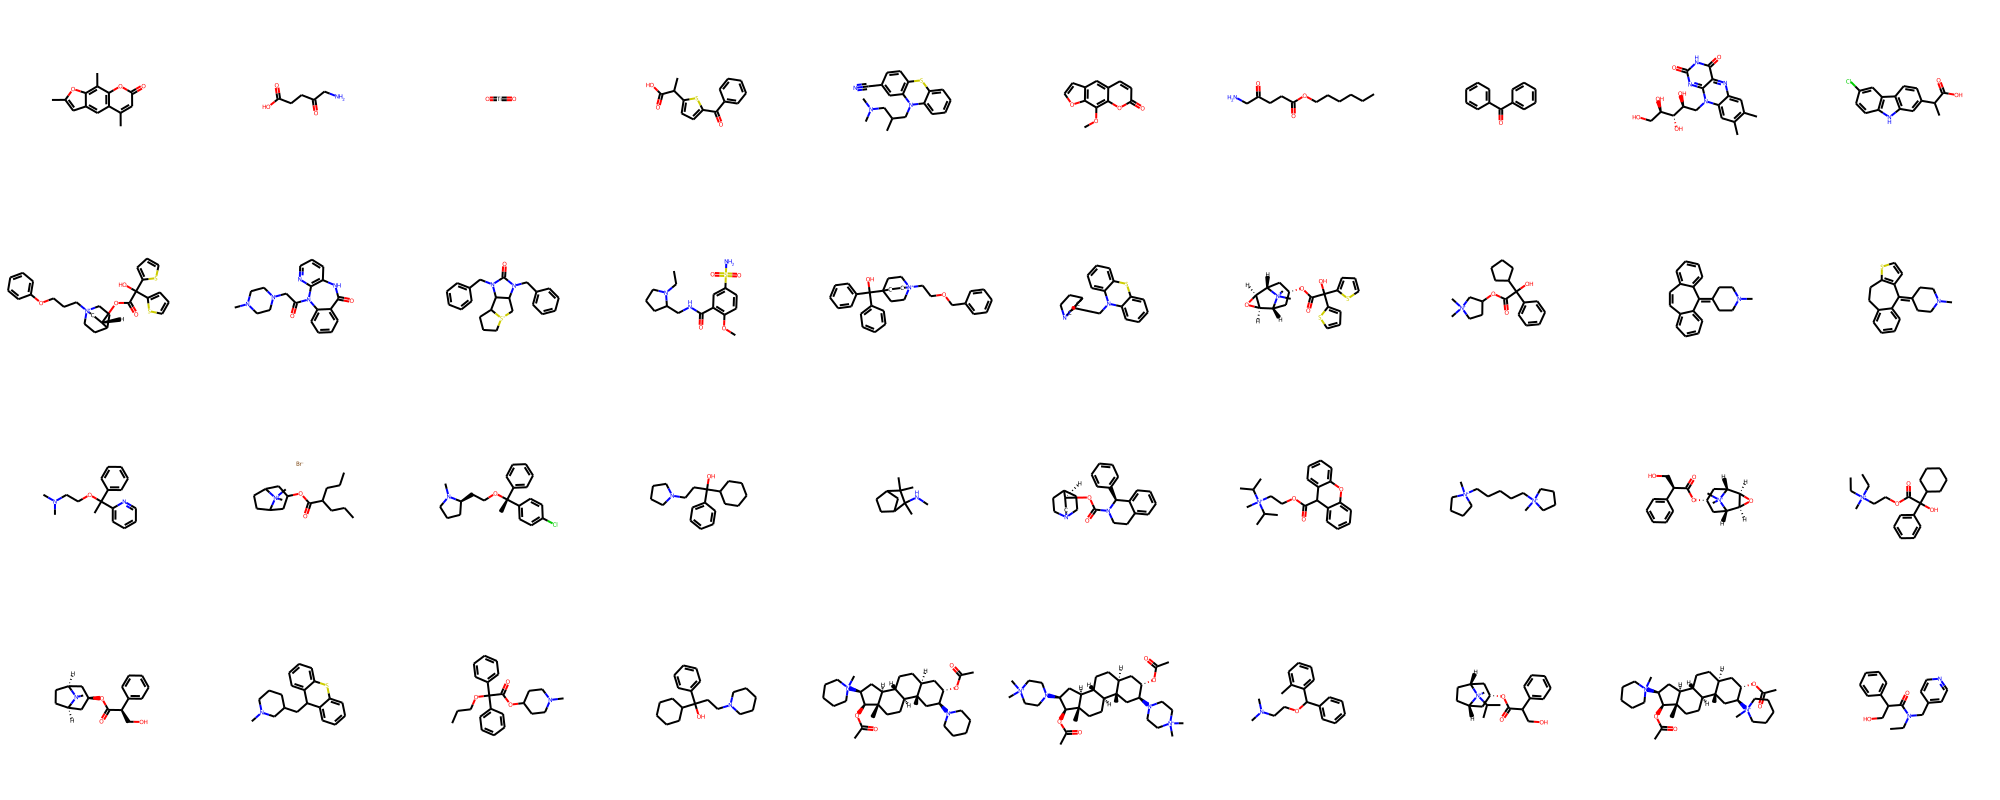

In [22]:
Draw.MolsToGridImage(uniq_mol.Mol.head(40), molsPerRow=10)

In [23]:
num_drugs = len(uniq_mol)
int((num_drugs * (num_drugs-1))/2)

1445850

In [24]:
# uniq_mol.iloc[0].Data

In [25]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 38], edge_attr=[38, 3], x=[17, 9])

In [26]:
# zhang_labels = pd.read_csv(rawdata_dir + '/DS1/drug_drug_matrix_wids.csv').set_index('Unnamed: 0')
# y_df = zhang_labels

In [27]:
%%time

y_df = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'y_df.pkl'),
                                     data_gen_fun = generate_labels_df,
                                     data_gen_params=(uniq_mol, datashort))

CPU times: user 2.38 ms, sys: 22.3 ms, total: 24.6 ms
Wall time: 43.8 ms


In [28]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

#y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [29]:
y_df

Drug_ID,DB04571,DB00855,DB09536,DB01600,DB09000,DB00553,DB06261,DB01878,DB00140,DB00821,...,DB05630,DB04967,DB08974,DB06816,DB11254,DB11121,DB00711,DB09061,DB00198,DB01284
Drug_ID,,,,,,,,,,,,,,,,,,,,,
DB04571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB01600,0,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,0,0,0,0,0
DB09000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB11121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# y_df[y_df > 0] = 1
# y_df

In [31]:
y = get_y_from_interactionmat(y_df.to_numpy())
len(y)

1445850

In [32]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
ReaderWriter.dump_data(y, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [34]:
report_label_distrib(y)

class: 0 norm count: 0.8677380087837604
class: 1 norm count: 6.916346785627832e-06
class: 2 norm count: 0.00022339800117577896
class: 3 norm count: 0.0003582667634955217
class: 4 norm count: 0.003420133485492963
class: 5 norm count: 0.0002137151156759
class: 6 norm count: 0.0021855655842583947
class: 7 norm count: 6.916346785627832e-07
class: 8 norm count: 0.0001687588615693191
class: 9 norm count: 0.0014586575370889097
class: 10 norm count: 0.0004350382128159906
class: 11 norm count: 0.00021164021164021165
class: 12 norm count: 0.0001646090534979424
class: 13 norm count: 3.112356053532524e-05
class: 14 norm count: 0.0002496801189611647
class: 15 norm count: 0.00013486876231974271
class: 16 norm count: 0.0037417436110246567
class: 17 norm count: 5.7405678320711e-05
class: 18 norm count: 5.6022408963585436e-05
class: 19 norm count: 7.538817996334336e-05
class: 20 norm count: 0.00421966317391154
class: 21 norm count: 0.0002960196424248712
class: 22 norm count: 6.501365978490161e-05
class

In [35]:
y_weights = compute_class_weights(torch.tensor(y))
y_weights

array([1.32462250e-02, 1.66189655e+03, 5.14519056e+01, 3.20829450e+01,
       3.36076148e+00, 5.37830599e+01, 5.25916630e+00, 1.66189655e+04,
       6.81105144e+01, 7.88002158e+00, 2.64212488e+01, 5.43103448e+01,
       6.98275862e+01, 3.69310345e+02, 4.60359156e+01, 8.52254642e+01,
       3.07189751e+00, 2.00228500e+02, 2.05172414e+02, 1.52467574e+02,
       2.72397402e+00, 3.88293587e+01, 1.76797506e+02, 2.96767241e+02,
       9.23275862e+01, 2.32108457e+01, 2.37413793e+03, 1.77553050e+01,
       1.51081505e+03, 5.12931034e+01, 2.69788401e+01, 1.18706897e+03,
       1.64381459e+01, 3.77703762e+01, 5.48480710e+01, 2.40854573e+02,
       1.76797506e+02, 5.38178935e+00, 5.03605016e+02, 1.12290308e+02,
       5.53965517e+01, 1.18706897e+03, 2.76982759e+03, 1.51081505e+03,
       1.27838196e+03, 5.03605016e+02, 6.39190981e+02, 4.86617636e-01,
       2.40854573e+02, 2.73815625e-01, 6.39190981e+02, 2.00228500e+02,
       1.66189655e+03, 4.94612069e+01, 1.30140685e+01, 1.40838691e+02,
      

In [36]:
ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [37]:
dpartitions = get_stratified_partitions(y, num_folds=10, valid_set_portion=0.1, random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [53]:
# pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
pairs = construct_sampleid_ddipairs(y_df.to_numpy())
len(pairs)

1445850

In [54]:
pairs

{0: (0, 1),
 1: (0, 2),
 2: (0, 3),
 3: (0, 4),
 4: (0, 5),
 5: (0, 6),
 6: (0, 7),
 7: (0, 8),
 8: (0, 9),
 9: (0, 10),
 10: (0, 11),
 11: (0, 12),
 12: (0, 13),
 13: (0, 14),
 14: (0, 15),
 15: (0, 16),
 16: (0, 17),
 17: (0, 18),
 18: (0, 19),
 19: (0, 20),
 20: (0, 21),
 21: (0, 22),
 22: (0, 23),
 23: (0, 24),
 24: (0, 25),
 25: (0, 26),
 26: (0, 27),
 27: (0, 28),
 28: (0, 29),
 29: (0, 30),
 30: (0, 31),
 31: (0, 32),
 32: (0, 33),
 33: (0, 34),
 34: (0, 35),
 35: (0, 36),
 36: (0, 37),
 37: (0, 38),
 38: (0, 39),
 39: (0, 40),
 40: (0, 41),
 41: (0, 42),
 42: (0, 43),
 43: (0, 44),
 44: (0, 45),
 45: (0, 46),
 46: (0, 47),
 47: (0, 48),
 48: (0, 49),
 49: (0, 50),
 50: (0, 51),
 51: (0, 52),
 52: (0, 53),
 53: (0, 54),
 54: (0, 55),
 55: (0, 56),
 56: (0, 57),
 57: (0, 58),
 58: (0, 59),
 59: (0, 60),
 60: (0, 61),
 61: (0, 62),
 62: (0, 63),
 63: (0, 64),
 64: (0, 65),
 65: (0, 66),
 66: (0, 67),
 67: (0, 68),
 68: (0, 69),
 69: (0, 70),
 70: (0, 71),
 71: (0, 72),
 72: (0, 73

In [55]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [56]:
%%time

X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

CPU times: user 4min 17s, sys: 1.83 s, total: 4min 19s
Wall time: 4min 19s


In [57]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

#X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [58]:
# X

In [59]:
%%time

dataset = MoleculeDataset(root=targetdata_dir)

Processing...
Done!


CPU times: user 49.5 s, sys: 33.8 s, total: 1min 23s
Wall time: 1min 37s


In [60]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(1445850):
Number of graphs: 1445850
Number of features: 9
Number of classes: 87


In [61]:
data0

PairData(edge_index_a=[2, 38], x_a=[17, 9], edge_attr_a=[38, 3], edge_index_b=[2, 16], x_b=[9, 9], edge_attr_b=[16, 3], id=[1], y=[1])

In [62]:
len(dataset)

1445850

In [43]:
test_percent = 99
len_train = int((100-test_percent) * (len(dataset)/100))
len_train

2076

In [44]:
torch.manual_seed(42)
dataset = dataset.shuffle()

In [45]:
train_dataset = dataset[:len_train]
test_dataset = dataset[len_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 14458
Number of test graphs: 1431392


In [46]:
train_dataset[3]

PairData(edge_attr_a=[30, 3], edge_attr_b=[50, 3], edge_index_a=[2, 30], edge_index_b=[2, 50], id=[1], x_a=[15, 9], x_b=[24, 9], y=[1])

In [47]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, follow_batch=['x_a', 'x_b'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, follow_batch=['x_a', 'x_b'])

In [44]:
# batch = next(iter(train_loader))
# print(batch)

In [45]:
uniq0 = uniq_mol.iloc[0].Data

In [46]:
uniq0.num_nodes

17

In [47]:
print(dataset.num_classes)

2


In [48]:
model_intermediate_dimension = 64

In [ ]:
model_name = "testGCN"

deepadr_model = testGCN(num_node_features=dataset.num_node_features, 
            hidden_channels=64, 
            num_classes=model_intermediate_dimension)
print(deepadr_model)

In [ ]:
deepadr_siamese = DeepAdr_SiameseTrf(input_dim=model_intermediate_dimension,
                                   dist='euclidean',
                                   num_classes=dataset.num_classes)

In [ ]:
models_param = list(deepadr_model.parameters()) + list(deepadr_siamese.parameters())

models = [(deepadr_model, model_name), (deepadr_siamese, f'{model_name}_Siamese')]
models

In [ ]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(models_param, lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_nlll = torch.nn.NLLLoss(reduction='mean')  # negative log likelihood loss
loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
fdtype = torch.float32
loss_w = 0.1

In [ ]:
def train():
    for m, m_name in models:
        m.train()

        #            for i_batch, samples_batch in enumerate(data_loader):

#     for data in train_loader:  # Iterate in batches over the training dataset.
    for i_batch, samples_batch in enumerate(train_loader):
        print("running batch:", i_batch)
        z_a = deepadr_model(samples_batch.x_a, samples_batch.edge_index_a, samples_batch.x_a_batch)
        z_b = deepadr_model(samples_batch.x_b, samples_batch.edge_index_b, samples_batch.x_b_batch)
        logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         loss = criterion(out, samples_batch.y)  # Compute the loss.
        cl = loss_nlll(logsoftmax_scores, samples_batch.y)            
        dl = loss_contrastive(dist.reshape(-1), samples_batch.y.type(fdtype))          
        loss = loss_w*cl + (1-loss_w)*dl
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    for m, m_name in models:
        m.eval()

    correct = 0
#     for data in loader:  # Iterate in batches over the training/test dataset.
    for i_batch, samples_batch in enumerate(loader):
#         out = model(data.x, data.edge_index, data.batch)  
        z_a = deepadr_model(samples_batch.x_a, samples_batch.edge_index_a, samples_batch.x_a_batch)
        z_b = deepadr_model(samples_batch.x_b, samples_batch.edge_index_b, samples_batch.x_b_batch)
        logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == samples_batch.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [ ]:
for epoch in range(1, 5):
    train()
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

### Generate datapartitions (i.e. train/val, test indices)

In [ ]:
dpartitions = get_stratified_partitions(y, num_folds=5, valid_set_portion=0.1, random_state=42)

In [ ]:
# dump data on disk
# targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

### Create Tensors

In [ ]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

### Using masking and inference with gip computation

In [ ]:
gip_perfold = {}
for fold_id in dpartitions:
    masked_intermat = interaction_mat.copy()
    masked_intermat = masked_intermat.astype(np.float)
    for dsettype in ('validation', 'test'):
        # get validation/test ddi pair indices
        sids = dpartitions[fold_id][dsettype]
        a = [sid_ddipairs_map[sid][0] for sid in sids]
        b = [sid_ddipairs_map[sid][1] for sid in sids]
        # set to nan
        masked_intermat[tuple([a,b])] = np.nan
        masked_intermat[tuple([b,a])] = np.nan
        
    intermat_infer_lst = []
    nanw_mat_lst = []
    for similarity_type in similarity_types:
        print('similarity_type', similarity_type)
        siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
        sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)
        imat_infer, nanw_m = impute_nan(masked_intermat, sim_mat, k=15)
        intermat_infer_lst.append(imat_infer)
        nanw_mat_lst.append(nanw_m)
        
    infer_mat_fus = weight_inferred_mat(nanw_mat_lst, intermat_infer_lst)

    print('norm(infer_mat-interaction_mat)', np.linalg.norm(infer_mat_fus - interaction_mat))

    # compute GIP here
    gip_kernel = compute_gip_kernel(infer_mat_fus, 1., kernel_option)
    print('norm(gip_kernel-interaction_mat)',np.linalg.norm(gip_kernel - interaction_mat))
    t = gip_kernel-interaction_mat
    print(np.sum(np.abs(t) > 0.5)/(t.size - t.shape[0]))
    gip_perfold[fold_id] = gip_kernel

### Compute features from similarity matrices

#### check if similarity matrix is symmetric

In [ ]:
num_sim_types = len(similarity_types)
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)   
    print(np.allclose(sim_mat, np.transpose(sim_mat)))

In [ ]:
num_sim_types = len(similarity_types)
X_feats = []
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    X_feat = preprocess_features(siminput_feat_pth, DSdataset_name, fill_diag=None)   
    X_feats.append(X_feat)
X_feat_cat = np.concatenate(X_feats, axis=1)
print("X_feat_cat", X_feat_cat.shape)

In [ ]:
X = create_setvector_features(X_feat_cat, 2*num_sim_types)
X.shape

In [ ]:
X_a = X[:,list(range(0,2*num_sim_types,2))].copy()
X_b = X[:,list(range(1,2*num_sim_types,2))].copy()

In [ ]:
from ddi.utilities import format_bytes
print(format_bytes(X_feat_cat.size * X_feat_cat.itemsize))
print(format_bytes(y.size * y.itemsize))

In [ ]:
# clear unused objects
del X_feats
del X_feat_cat
del X_feat

In [ ]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

In [ ]:
# dtype is float32 since we will use sigmoid (binary outcome)
y_tensor = torch.tensor(y, dtype = torch.int64, device = device_cpu) 
X_a = torch.tensor(X_a, dtype = torch.float32, device = device_cpu)
X_b = torch.tensor(X_b, dtype = torch.float32, device = device_cpu)
ddi_datatensor = DDIDataTensor(X_a, X_b, y_tensor)

In [ ]:
targetdata_dir

In [ ]:
# dump data on disk
ReaderWriter.dump_tensor(X_a, os.path.join(targetdata_dir, 'X_a.torch'))
ReaderWriter.dump_tensor(X_b, os.path.join(targetdata_dir, 'X_b.torch'))
ReaderWriter.dump_tensor(y_tensor, os.path.join(targetdata_dir, 'y_tensor.torch'))

### Construct GIP datatensor for each fold

In [ ]:
gip_dtensor_perfold = {}
for fold_id in gip_perfold:
    print('fold_id:', fold_id)
    gip_mat = gip_perfold[fold_id]
    print('gip_mat:', gip_mat.shape)
    gip_feat = get_features_from_simmatrix(gip_mat)
    gip_all = create_setvector_features(gip_feat, 2)
    print('gip_all:', gip_all.shape)
    X_a_gip = gip_all[:,list(range(0,2*1,2))].copy()
    X_b_gip = gip_all[:,list(range(1,2*1,2))].copy()
    print('X_a_gip:', X_a_gip.shape)
    X_a_gip = torch.tensor(X_a_gip, dtype = torch.float32, device = device_cpu)
    X_b_gip = torch.tensor(X_b_gip, dtype = torch.float32, device = device_cpu)
    gip_datatensor = GIPDataTensor(X_a_gip, X_b_gip)
    gip_dtensor_perfold[fold_id] = gip_datatensor

In [ ]:
# dump data on disk
ReaderWriter.dump_tensor(gip_dtensor_perfold, os.path.join(targetdata_dir, 'gip_dtensor_perfold.torch'))